<a href="https://colab.research.google.com/github/jeremycheminf/colab_notebooks/blob/main/generate_features_chembl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate features from ChEMBL and then lookup

One way to filter generative Ai design is to remove odd structures that are generated. Ring systems is one of the option, https://practicalcheminformatics.blogspot.com/2024/05/generative-molecular-design-isnt-as.html but we can also look at fingerprint features which represent some substructure pattern.
RDKit can generate unfolded fingerprint and we can store information as a very long list of integers and information on occurences. Similar to SAScore feature subscore.
In this notebook, equiavalent of ECFP4 are used, but one could change to other representation.

Additionaly the Counter object created can be updated with a list of compounds-features to reflect particular chemical space.

Let's install libraries we need

In [ ]:
! pip install rdkit swifter datamol

## Generate files for features from ChEMBL

ChEMBL downloaded from FTP with just representation of compounds chembl_34_chemreps.txt.gz

In [12]:
file_chembl = "https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_34_chemreps.txt.gz"


All our imports and stop RDKit logging

In [13]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
from tqdm.auto import tqdm
from itertools import chain
from collections import Counter
import swifter
import datamol as dm # for RDKit logging

RDLogger.DisableLog("rdApp.info")

Now we read ChEMBL file in pandas and change column name (optional)

In [15]:
df = pd.read_csv(
    file_chembl, compression="gzip", sep="\t", usecols=["canonical_smiles"]
)
df = df.drop_duplicates()
df = df.rename(columns={"canonical_smiles": "SMILES"})

In [16]:
df.head()

,SMILES
0,Cc1cc(-c2csc(N=C(N)N)n2)cn1C
1,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...
2,CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(...
3,CC(C)C[C@@H]1NC(=O)CNC(=O)[C@H](c2ccc(O)cc2)NC...
4,Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1


### Features

We need to get unique fingerprint feature as unfolded integer. Then count how many compounds have the feature. This is counting only 1 per compound even if feature is present multiple times on a same molecule.

We will define a set of functions to generate and lookup

In [20]:
frm = rdMolStandardize.LargestFragmentChooser()

def unfolded_set_fps(smi: str) -> set:
    '''
    This takes a smiles and return a set of integer representing ECFP4 on bits
    To help with calculation, compounds with more than 50 atoms are discarded
    smi: SMILES of the compound
    '''
    try:
        with dm.without_rdkit_log():
            mol = Chem.MolFromSmiles(smi)
            if mol is None or mol.GetNumHeavyAtoms() > 50:
                return set()
            mol = frm.choose(mol)
            return set(
                rdMolDescriptors.GetMorganFingerprint(mol, 2, useCounts=False)
                .GetNonzeroElements()
                .keys()
            )
    except Exception as e:
        return set()

def lookup_fps(smi: str, counter: Counter) -> dict:
    '''
    This takes a smiles and a counter object containing fps occurences to return for the smiles the list of features and frequencies as a dictionary
    smi: SMILES of the compound
    counter: Counter object contianing all the lookup table
    '''
    dict_out = {}
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return dict_out
        res = set(
            rdMolDescriptors.GetMorganFingerprint(mol, 2).GetNonzeroElements().keys()
        )
        for item in res:
            dict_out[item] = counter[item]
        return dict_out
    except Exception as e:
        return {}


def fps_low_frequency(fps_dict: dict, threshold: int = 10) -> int:
    '''
    From a dictionary of values, return how many values are below threshold
    Passing the output of lookup_fps will return how many features in a compound are below threshold
    fps_dict: dictionary in format {fpds_x: occurence}
    threshold: Max value to count as low occuring feature
    '''
    return sum(1 for v in fps_dict.values() if v < threshold)


def mol_fps_low_frequency(smi: str, counter: Counter, threshold: int = 10) -> int:
    '''
    Helper function to combine look up and low frequency to get from a smiles to how many features the molecule has below threshold
    counter: Counter object contianing all the lookup table
    threshold: Max value to count as low occuring feature
    '''
    return fps_low_frequency(lookup_fps(smi, counter), threshold)

We will use swifter library to speed calculations and get all fps, then Counter to count all the fingerprint integer values

Note: this can take some time to run depending of CPU available

In [18]:
df["set_of_integers"] = df["SMILES"].swifter.apply(unfolded_set_fps)

Pandas Apply:   0%|          | 0/2409117 [00:00<?, ?it/s]

The chain/from_iterable_tolist functions will collapse all the df into a big list that Counter will count and create a dictionary with key the fps "number" and count as tally counter.

In [19]:
c = Counter(chain.from_iterable(df["set_of_integers"].tolist()))

Now we save the data in parquet for later

In [21]:
df_count = pd.DataFrame.from_dict(c, orient="index").reset_index()
df_count.columns = ["fp_code", "count"]
df_count.to_parquet("fp_counts.parquet", engine="pyarrow", compression="snappy")

How to use the file to see on compounds

In [22]:
# Read the parquet file into a DataFrame
df_fps = pd.read_parquet("fp_counts.parquet")

# Create a new counter
counter = dict(zip(df_fps["fp_code"], df_fps["count"]))
counter = Counter(counter)

In [24]:
print(f" there are {counter[2353112200]} compounds with feature 2353112200")

 there are 395849 compounds with feature 2353112200


And look up to show all features with occurences, and counting how many features are seen less than n times

In [25]:
n = 1000
print(lookup_fps("CCCOCCCCC", counter))
print(mol_fps_low_frequency("CCCOCCCCC", counter, n))

{1891839201: 21938, 2246728737: 1680388, 3745584548: 46619, 2636383078: 6005, 3542456614: 388168, 2215059400: 24274, 864674487: 942769, 4008337421: 133099, 4026668333: 4604, 1685248591: 81593, 2245384272: 1552528, 4232889011: 5183, 1510461303: 249947, 2728141400: 423, 1173125914: 134149}
1


#### Show how to look at SMARTS of feature

But need a compound, the information is not stored in the file. We will get a random compound, generate bit info and show the SMARTS and picture of it

In [26]:
mol = Chem.MolFromSmiles("CCCOC")
bit_info = {}
fp = rdMolDescriptors.GetMorganFingerprint(mol, 2, bitInfo=bit_info)  # get bit info this time
bit_info

{864674487: ((3, 0),),
 1173125914: ((1, 1),),
 2222621677: ((3, 1),),
 2245384272: ((1, 0), (2, 0)),
 2246728737: ((0, 0), (4, 0)),
 2636383078: ((1, 2),),
 2786563569: ((2, 2),),
 3183067622: ((3, 2),),
 3542456614: ((0, 1),),
 3975275337: ((4, 1),),
 4008337421: ((2, 1),)}

In [27]:
atomidx, radius = bit_info[2786563569][
    0
]  # 2786563569 is an example
env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atomidx)  # returns rdkit vector
submol = Chem.PathToSubmol(mol, env)
Chem.MolToSmarts(submol)

'[#6]-[#6]-[#6]-[#8]-[#6]'

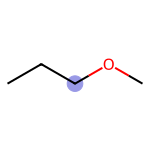

In [28]:
Chem.Draw.DrawMorganBit(mol, 2786563569, bit_info)

## More features?

As shown by Greg Landrum with a 6M ZINC file, "The thing that I find most interesting (and somewhat surprising) about these results is how far we are from having encountered “all” of the bits; new bits are being encountered for almost all of the fingerprint types even after 5.9 million molecules have been encountered."  https://greglandrum.github.io/rdkit-blog/posts/2022-01-04-number-of-unique-fp-bits.html

If looking to go to surechembl, this is a lot slower!

### Use Surechembl data for features

In [9]:
# Download HTML content
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

import os

from bs4 import BeautifulSoup

url = "https://ftp.ebi.ac.uk/pub/databases/chembl/SureChEMBL/data/"
response = requests.get(url)
html_content = response.text

In [ ]:
# Parse HTML and extract file links
soup = BeautifulSoup(html_content, "html.parser")

file_links = [
    url + anchor["href"]
    for anchor in soup.find_all("a")
    if anchor["href"].endswith(".txt.gz")
]

counter_all = Counter()

# Download and process each file

for file_url in file_links:
    file_name = file_url.split("/")[-1]
    print(f"Downloading and processing {file_name}...")
    if os.path.exists(file_name):
        print("no need to download")
    else:
        response = requests.get(file_url)
        # Write the gzipped content to a file
        with open(file_name, "wb") as f:
            f.write(response.content)
    pandas_df = pd.read_csv(
        file_name,
        sep="\t",
        usecols=["SMILES"],
    )
    chunk_size = 1000000
    if len(pandas_df) > chunk_size:
        for i in range(0, len(pandas_df), chunk_size):
            chunk = pandas_df.iloc[i : i + chunk_size]
            # Use swifter to parallelize the apply function on the chunk
            chunk["set_of_integers"] = chunk["SMILES"].swifter.apply(unfolded_set_fps)
            c = Counter(chain.from_iterable(chunk["set_of_integers"].tolist()))
            counter_all.update(c)
    else:
        pandas_df["set_of_integers"] = pandas_df["SMILES"].swifter.apply(
            unfolded_set_fps
        )
        c = Counter(chain.from_iterable(pandas_df["set_of_integers"].tolist()))
        counter_all.update(c)

In [ ]:
df_count = pd.DataFrame.from_dict(counter_all, orient="index").reset_index()
df_count.columns = ["fp_code", "count"]
df_count.to_parquet(
    "fp_counts_surechembl.parquet", engine="pyarrow", compression="snappy"
)

#### Test the file

In [ ]:
# Read the parquet file into a DataFrame
df_fps = pd.read_parquet("fp_counts_surechembl.parquet")

# Create a new counter
counter = dict(zip(df_fps["fp_code"], df_fps["count"]))
counter = Counter(counter)

In [ ]:
print(lookup_fps("CCCOCCCCC", counter))
print(mol_fps_low_frequency("CCCOCCCCC", counter, 50000))